# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
We want to train a model such that it is able to classify the incoming data point which is a reveiw text into positive review and negative review .For this task we will take in consideration of the review text and will work on it using different vectorizers like Bag of words,tfidf,and word to vector to generate features that can be feeded to our model for making predictions

<br>
####  [Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle

from tqdm import tqdm
import os

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('gdrive/My Drive/database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [17]:
final = final.sample(100000)
final = final.sort_values('Time',ascending = True)

#considering the 50k datapoints
final.head(20)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...
121041,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,1,965001600,End your Gopher Problems,I have just recently purchased the Woodstream ...
138001,149770,B00004S1C5,A1KXONFPU2XQ5K,Stephanie Manley,8,8,1,965779200,Very easy to use,This are so much easier to use than the Wilson...
346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,1,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...
138000,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,1,975974400,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...
346054,374358,B00004CI84,A1HWMNSQF14MP8,will@socialaw.com,1,2,1,978134400,A Afterlife Success,"Many movies, have dealt with the figure of dea..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,1,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
346032,374334,B00004CI84,A2HIZRVOKXKZ52,KAY N. FOWLER,0,0,1,1012780800,Beetlejuice - Great Fun for Everyone!,When vacationing Adam and Barbara Maitland mee...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# Combining all the above statements
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in (final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    #sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [20]:
preprocessed_reviews[11]

'I am never dissapointed with the great gadgets this company comes out with My brother picked up the new Concerto for me and it is absolutely awesome My wife likes whites and I like reds so the stoppers really come in handy Also I love the new clicking sound it makes when the vacuum is at the correct level Neat design great looking gift the absolute best invention for saving wines'

<h2><font color='red'>[3.2] Preparing the data for input to the model</font></h2>

<h2><font color='red'>[3.2] Preparing the data for input to the model</font></h2>
### We want to input the data in the format of padded vectors which comprises of ranks of words,it is a manual implementation of text tokenizer.So the methodology to be followed is:
   - Counting the number of times a particular word appears in the training corpus.
   - Giving the word with most number of occurence rank 1 and so on 
   - Sorting the list to get all the ranks in the corpus

In [0]:
#splitting the data
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,final['Score'],test_size = 0.2,random_state = 0,shuffle =False)

In [22]:
from collections import defaultdict
word_dict = defaultdict(int)#dictionary containing the count of words in the reviews


# we will split every review and then use a dictionary to count the number of times a word appears in the training corpus
for review in X_train:
  for word in review.split():
    word_dict[word] += 1

print('number of unique words in the corpus are:',len(word_dict.keys()))
print('\n')

print('THe corpus with count of each words and number of times they occur are:',word_dict)


number of unique words in the corpus are: 71697


THe corpus with count of each words and number of times they occur are: defaultdict(<class 'int'>, {'I': 222655, 'can': 24065, 'remember': 825, 'seeing': 285, 'the': 221973, 'show': 361, 'when': 15226, 'it': 120304, 'aired': 2, 'on': 36962, 'television': 15, 'years': 5303, 'ago': 2045, 'was': 43720, 'a': 160004, 'child': 544, 'My': 12058, 'sister': 397, 'later': 1065, 'bought': 6717, 'me': 16896, 'LP': 1, 'which': 10069, 'have': 59883, 'to': 137188, 'this': 71489, 'day': 6072, 'am': 19891, 'thirty': 62, 'something': 4914, 'used': 7814, 'series': 45, 'of': 106385, 'books': 99, 'songs': 6, 'did': 9760, 'my': 48171, 'student': 105, 'teaching': 17, 'for': 72283, 'preschoolers': 3, 'turned': 795, 'whole': 3744, 'school': 472, 'now': 7423, 'purchasing': 853, 'CD': 19, 'along': 1168, 'with': 47757, 'children': 688, 'The': 30580, 'tradition': 94, 'lives': 223, 'myself': 1819, 'always': 4897, 'enjoyed': 1465, 'movie': 283, 'is': 143444, 'very': 

In [23]:
'''We now want to get a training corpus with each if the words with their respective ranks i.e if a word occurs maximum
  Number of times in the corpus it will have a rank 1 and subsequently'''


#data frame for word and their frequencies
table = pd.DataFrame.from_dict(word_dict,orient = 'index', columns = ['Frequency'])
#sorting for the frequencies
table = table.sort_values('Frequency',ascending = False)
print(table.head(20))#top 20 words which are repeated most number of times are 


top_words = list(table.index)
#top_words = top_words[:10000]
print('Number of words are :',len(top_words))



#we will create a dictionary to find the rank of the word appearing in the corpus
rank_dict = dict()
rank = 1
for i in top_words:
  rank_dict[i] = rank
  rank = rank + 1

print(rank_dict)
vocab_size = len(rank_dict.keys())
print('Number of unique words in the rank dictionary are ',vocab_size)


      Frequency
I        222655
the      221973
and      173961
a        160004
is       143444
to       137188
it       120304
of       106385
not       78621
in        74139
for       72283
this      71489
have      59883
that      57438
are       48905
my        48171
with      47757
you       47634
was       43720
but       43033
Number of words are : 71697
{'I': 1, 'the': 2, 'and': 3, 'a': 4, 'is': 5, 'to': 6, 'it': 7, 'of': 8, 'not': 9, 'in': 10, 'for': 11, 'this': 12, 'have': 13, 'that': 14, 'are': 15, 'my': 16, 'with': 17, 'you': 18, 'was': 19, 'but': 20, 'on': 21, 'as': 22, 'like': 23, 'The': 24, 'they': 25, 'so': 26, 'It': 27, 'them': 28, 'good': 29, 'be': 30, 'or': 31, 'can': 32, 'at': 33, 'these': 34, 'will': 35, 'taste': 36, 'This': 37, 'one': 38, 'just': 39, 'do': 40, 'very': 41, 'would': 42, 'product': 43, 'great': 44, 'from': 45, 'am': 46, 'all': 47, 'flavor': 48, 'coffee': 49, 'has': 50, 'more': 51, 'tea': 52, 'had': 53, 'me': 54, 'than': 55, 'out': 56, 'when': 57, 'lo

In [0]:
#now we want to create the data set for test and train
#after getting our word and rank dictionary ,we now want training and test data set 


x_train = []#larger vector which will contain all the encoded reviews for traininfg data
x_test = []#larger vector which will contain all the encoded reveiws for test data 

#X_train
for rev in X_train:
    row = []#for each review vector
    for word in rev.split():
        if word in rank_dict.keys():
        row.append(rank_dict[word])
    x_train.append(row)
    
#X_test
#(as to avoiding the data leakage we will get the test word vectors with the help of training data)
for rev in X_test:
    row = []
    for word in rev.split():
        if word in rank_dict.keys():
        row.append(rank_dict[word])
    x_test.append(row)


In [26]:
print(x_train[1])
print(len(x_train))


[1, 438, 167, 503, 12, 1827, 7, 5, 41, 2024, 3, 6187, 26, 1, 91, 9, 2702, 6, 806, 62, 2, 37675, 6798, 1, 666, 7, 19, 4, 2956, 924, 6, 84, 2, 1827, 51, 11, 5139, 31, 166, 20, 25, 13, 5764, 47, 227, 43427, 3, 7156, 14, 15, 322, 14077, 10, 2, 11312, 504, 1433, 1892, 5874, 15439, 104, 18, 152, 2, 18396, 504, 10746, 542, 43488, 41571]
80000
20000


## # WE will use three different architectures for model implementation
- Model with 2 hidden layers 
- Model with 3 hidden layers
- Model with 5 hidden layers

 __In Each Architecture We will implement using Adam optimizer__:
 
 - 1 LSTM + Adam
 - 2 LSTM + Adam
 - 2 CNN + 1 LSTM + Adam 

In [0]:
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.initializers import he_normal
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.regularizers import L1L2
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Flatten

In [29]:
#using the padding for each of the reviews
max_review_length = 400


X_train = sequence.pad_sequences(x_train,maxlen = max_review_length)
X_test = sequence.pad_sequences(x_test,maxlen = max_review_length)


print(X_train.shape)
print(X_train[1])

(80000, 400)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

In [0]:
#model settings

batch_size = 200 #number of data points as input to the model in each iteration
#number of times whole data will pass through the model
nb_epochs = 10
#length of the embedding vector
embedd_vector = 32

In [0]:
import warnings
warnings.filterwarnings('ignore')

## Model 1: 1 LSTM(100) + 2 DROPOUT + 1 BATCHNORMALIZATION + ADAM OPTIMIZER

In [32]:
model = Sequential()
model.add(Embedding(vocab_size,embedd_vector,input_length = max_review_length))
model.add(BatchNormalization())#adding the batchnormalization layer
model.add(Dropout(0.3))#adding a dropout layer before the LSTM model
model.add(LSTM(100))
model.add(Dropout(0.3))#adding a dropout layer before the output layer 
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 32)           2294304   
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 32)           128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_____________________________________

In [33]:
history = model.fit(X_train,Y_train,batch_size = batch_size,epochs = nb_epochs,verbose = 1,validation_data = (X_test,Y_test))




Train on 80000 samples, validate on 20000 samples
Epoch 1/10





80000/80000 [==============================] - 302s 4ms/step - loss: 0.2949 - acc: 0.8818 - val_loss: 0.2988 - val_acc: 0.8935
Epoch 2/10
80000/80000 [==============================] - 297s 4ms/step - loss: 0.1614 - acc: 0.9386 - val_loss: 0.1931 - val_acc: 0.9239
Epoch 3/10
80000/80000 [==============================] - 297s 4ms/step - loss: 0.1124 - acc: 0.9584 - val_loss: 0.2540 - val_acc: 0.9183
Epoch 4/10
80000/80000 [==============================] - 297s 4ms/step - loss: 0.0817 - acc: 0.9708 - val_loss: 0.2517 - val_acc: 0.9220
Epoch 5/10
80000/80000 [==============================] - 298s 4ms/step - loss: 0.0589 - acc: 0.9793 - val_loss: 0.2759 - val_acc: 0.9219
Epoch 6/10
80000/80000 [==============================] - 296s 4ms/step - loss: 0.0462 - acc: 0.9843 - val_loss: 0.3062 - val_acc: 0.9220
Epoch 7/10
80000/80000 [==============================] - 297s 4ms/step - loss: 0.0350 - acc: 0.9881 - val_loss: 0

In [34]:
score = model.evaluate(X_test,Y_test)
print('loss on testd data is :',score[0])
print('Accuracy on test data is ',score[1])

20000/20000 [==============================] - 158s 8ms/step
loss on testd data is : 0.38287709151050076
Accuracy on test data is  0.92025


In [0]:
import pickle

def savetofile(obj,filename):
  pickle.dump(obj,open(filename+".p",'wb'))


def openfromfile(filename):
  temp = pickle.load(open(filename+".p",'rb'))
  return temp

history_1 = savetofile(history,'history_1')
model1 = savetofile(model,'model1')

In [0]:
# Model 2

# MODEL 2 : lstm(100 cells) + lstm(50 cells)+ Sigmoid + Adam Optimizer + dropout + BatchNormalization

In [38]:
from keras.initializers import glorot_normal

model = Sequential()
model.add(Embedding(vocab_size,embedd_vector,input_length = max_review_length))
model.add(BatchNormalization())#adding the batchnormalization layer
model.add(Dropout(0.3))#setting the dropout rate to 3 which means 30 percent of the neurons will be considered inactive while doing the computation
model.add(LSTM(100,return_sequences=True))
#model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(50))
model.add(Dropout(0.3))
model.add(Dense(1,activation = 'sigmoid'))#adding the output layer
print(model.summary())





Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 400, 32)           2294304   
_________________________________________________________________
batch_normalization_3 (Batch (None, 400, 32)           128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 400, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 400, 100)          53200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 400, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)               

In [39]:
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
history = model.fit(X_train,Y_train,batch_size = batch_size ,epochs = nb_epochs ,verbose = 1,validation_data=(X_test,Y_test))

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 603s 8ms/step - loss: 0.2760 - acc: 0.8897 - val_loss: 0.2489 - val_acc: 0.9133
Epoch 2/10
80000/80000 [==============================] - 596s 7ms/step - loss: 0.1543 - acc: 0.9419 - val_loss: 0.1936 - val_acc: 0.9273
Epoch 3/10
80000/80000 [==============================] - 600s 7ms/step - loss: 0.1071 - acc: 0.9606 - val_loss: 0.2108 - val_acc: 0.9269
Epoch 4/10
80000/80000 [==============================] - 603s 8ms/step - loss: 0.0742 - acc: 0.9743 - val_loss: 0.2389 - val_acc: 0.9272
Epoch 5/10
80000/80000 [==============================] - 598s 7ms/step - loss: 0.0531 - acc: 0.9817 - val_loss: 0.2871 - val_acc: 0.9251
Epoch 6/10
80000/80000 [==============================] - 587s 7ms/step - loss: 0.0408 - acc: 0.9864 - val_loss: 0.2914 - val_acc: 0.9258
Epoch 7/10
80000/80000 [==============================] - 592s 7ms/step - loss: 0.0316 - acc: 0.9898 - val_loss: 0.3008 - 

In [40]:
score  = model.evaluate(X_test,Y_test)
print('Loss on test data is',score[0])
print('Accuracy on test data is ',score[1])

20000/20000 [==============================] - 304s 15ms/step
Loss on test data is 0.3902494033191353
Accuracy on test data is  0.92185


In [0]:
history_2 = savetofile(history,'history_2')
model_2 = savetofile(model,'model_2')

In [0]:
import warnings
warnings.filterwarnings('ignore')

## MODEL 3: 2 Convolutional layer + Maxpooling +  LSTM(80) + BatchNormaliztion + Dropout + Adamoptimizer

In [43]:
#using a CNN and RNN model combined for sequence classification
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model = Sequential()
model.add(Embedding(vocab_size,embedd_vector,input_length = max_review_length))
model.add(LSTM(80,return_sequences =True))
model.add(Dropout(0.5))
model.add(Conv1D(filters = 128,kernel_size = 5,padding = 'same',activation = 'relu',kernel_initializer = he_normal(seed = None)))
model.add(MaxPooling1D(5,5))
#model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(filters = 128,kernel_size = 5,padding = 'same',activation = 'relu',kernel_initializer = he_normal(seed = None)))
model.add(MaxPooling1D(5,5))
#model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128,activation = 'relu',kernel_initializer = he_normal(seed = None)))
model.add(Dropout(0.4))
model.add(Dense(1,activation = 'sigmoid'))

print(model.summary())



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 400, 32)           2294304   
_________________________________________________________________
lstm_6 (LSTM)                (None, 400, 80)           36160     
_________________________________________________________________
dropout_9 (Dropout)          (None, 400, 80)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 128)          51328     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 80, 128)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 80, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 128)        

In [44]:
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

history = model.fit(X_train,Y_train,batch_size = batch_size,epochs = nb_epochs,validation_data = [X_test,Y_test])

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 316s 4ms/step - loss: 0.2710 - acc: 0.8918 - val_loss: 0.2000 - val_acc: 0.9247
Epoch 2/10
80000/80000 [==============================] - 311s 4ms/step - loss: 0.1418 - acc: 0.9475 - val_loss: 0.1809 - val_acc: 0.9295
Epoch 3/10
80000/80000 [==============================] - 311s 4ms/step - loss: 0.0937 - acc: 0.9660 - val_loss: 0.2105 - val_acc: 0.9245
Epoch 4/10
80000/80000 [==============================] - 312s 4ms/step - loss: 0.0653 - acc: 0.9769 - val_loss: 0.2405 - val_acc: 0.9179
Epoch 5/10
80000/80000 [==============================] - 311s 4ms/step - loss: 0.0467 - acc: 0.9837 - val_loss: 0.2782 - val_acc: 0.9213
Epoch 6/10
80000/80000 [==============================] - 312s 4ms/step - loss: 0.0352 - acc: 0.9877 - val_loss: 0.3719 - val_acc: 0.9188
Epoch 7/10
80000/80000 [==============================] - 313s 4ms/step - loss: 0.0275 - acc: 0.9907 - val_loss: 0.3611 - 

In [45]:
score = model.evaluate(X_test,Y_test)
print('loss on test data is:',score[0])
print('Accuracy on test data is',score[1])

history_3 = savetofile(history,'history_3')

20000/20000 [==============================] - 155s 8ms/step
loss on test data is: 0.507415438480489
Accuracy on test data is 0.9171


## PLOTS

In [0]:
def diff_ops(model_h,text):

  x = list(range(1,(nb_epochs)+1))#definig the bin size on the x axis as we want to plot for each of the epochs
  plt.figure(figsize = (22,8))
  #plt.grid()


    #this plots the loss vs epochs for each model
  plt.subplot(2,2,1)
  plt.grid()
  plt.plot(x,model_h.history['val_loss'],'b',label = 'Test loss')#test loss
  plt.plot(x,model_h.history['loss'],'r',label = 'Training Loss')#train loss
  plt.xlabel('Epochs')
  plt.ylabel('Binary Cross Entropy')
  plt.title(text)
  plt.legend(loc = 'best')

#=======================================================================================
    #this plots the test and train accuracy for each model
  plt.subplot(2,2,2)
  plt.grid()
  plt.plot(x,model_h.history['val_acc'],'b',label = 'Test Accuracy')#test accuracy
  plt.plot(x,model_h.history['acc'],'r',label = 'Training Accuracy')#training accuracy
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title(text)
  plt.legend(loc = 'best')
  plt.show()
  




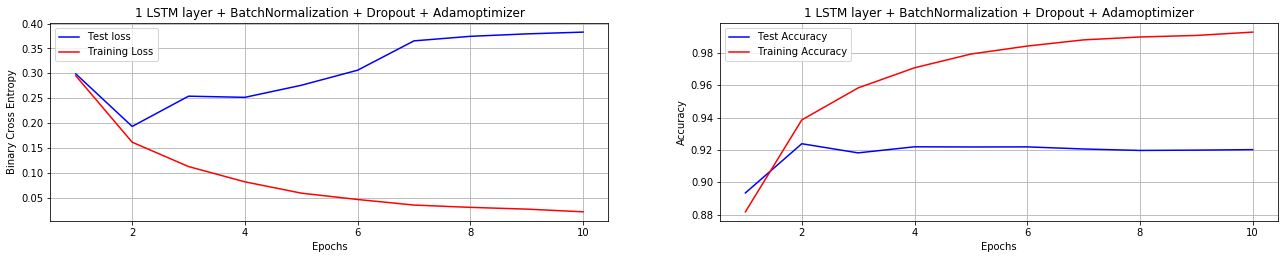

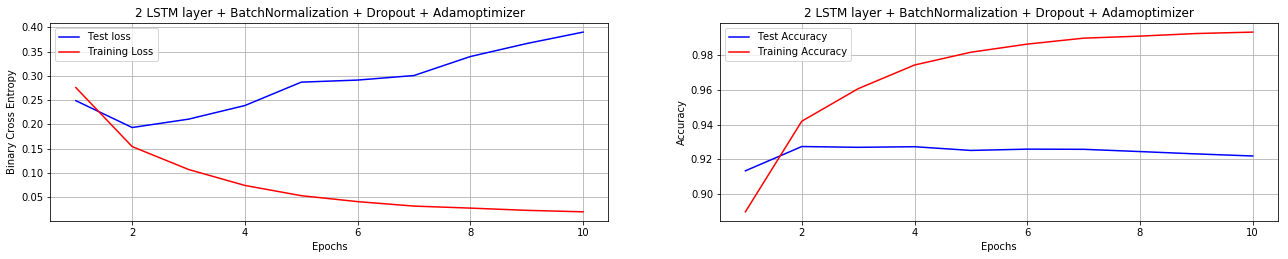

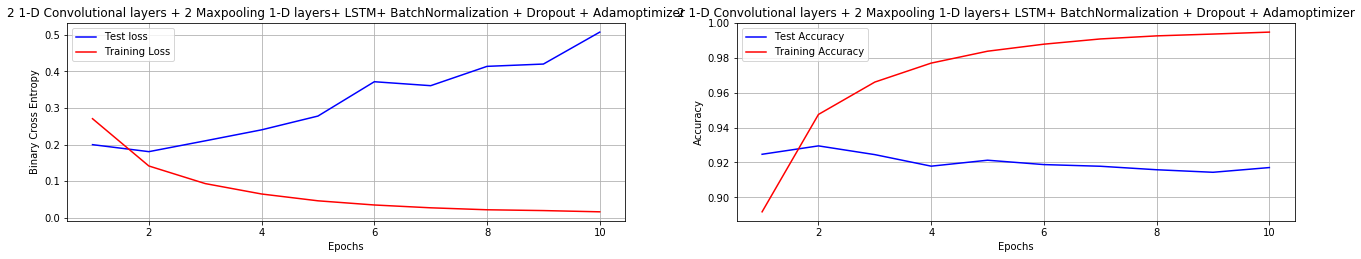

In [47]:
text = '1 LSTM layer + BatchNormalization + Dropout + Adamoptimizer'
diff_ops(openfromfile('history_1'),text)

text = '2 LSTM layer + BatchNormalization + Dropout + Adamoptimizer'
diff_ops(openfromfile('history_2'),text)

text = '2 1-D Convolutional layers + 2 Maxpooling 1-D layers+ LSTM+ BatchNormalization + Dropout + Adamoptimizer'
diff_ops(openfromfile('history_3'),text)


## Conclusions

In [48]:
from prettytable import PrettyTable

history1 = openfromfile('history_1')#model 1
history2 = openfromfile('history_2')#model 2
history3 = openfromfile('history_3')#model 3

table_arch1 = PrettyTable()
models = ['1 LSTM + BatchNormalization + Dropout + AdamOptimizer','2 LSTM + BatchNormalization + Dropout + AdamOptimizer ',\
          '1 LSTM + 2 1D Convolutional Layers + 2 Maxpooling layers + BatchNormalization + Dropout + AdamOptimizer']
tr_loss = [history1.history['loss'][nb_epochs-1],history2.history['loss'][nb_epochs-1],history3.history['loss'][nb_epochs-1]]
tr_acc = [history1.history['acc'][nb_epochs-1],history2.history['acc'][nb_epochs-1],history3.history['acc'][nb_epochs-1]]
te_loss = [history1.history['val_loss'][nb_epochs-1],history2.history['val_loss'][nb_epochs-1],history3.history['val_loss'][nb_epochs-1]]
te_acc = [history1.history['val_acc'][nb_epochs-1],history2.history['val_acc'][nb_epochs-1],history3.history['val_acc'][nb_epochs-1]]

table_arch1.add_column('Model',models)
table_arch1.add_column('trainig loss',tr_loss)
table_arch1.add_column('Training Accuracy(%)',tr_acc)
table_arch1.add_column('Test loss',te_loss)
table_arch1.add_column('Test_Accuracy(%)',te_acc)
print('\t\t\t\t\t\t\t\t 3 Different Models')
print(table_arch1)
print('\n\n\n')

								 3 Different Models
+---------------------------------------------------------------------------------------------------------+----------------------+----------------------+--------------------+--------------------+
|                                                  Model                                                  |     trainig loss     | Training Accuracy(%) |     Test loss      |  Test_Accuracy(%)  |
+---------------------------------------------------------------------------------------------------------+----------------------+----------------------+--------------------+--------------------+
|                          1 LSTM + BatchNormalization + Dropout + AdamOptimizer                          | 0.02137223101221025  |  0.9928750067949295  | 0.3828770938515663 | 0.9202500039339065 |
|                          2 LSTM + BatchNormalization + Dropout + AdamOptimizer                          | 0.019836417277983857 |  0.9932750064134598  | 0.3902494059503078 | 0.92185000538

We get the model with 2 lstm layers i.e 0.921 to perform slightly better than model with single lstm .Though it performs far better than CNN + RNN model .This tells us that better accuracy can be attained by hyperparameter tuning using gridsearch cv.We can also use a Bidirectional LSTM for much better accuracy.